In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title Setup
!pip install git+https://github.com/google-research/google-research.git#subdirectory=sd_gym
!pip install dm-acme[jax,tf]
!pip install dm-sonnet

### Download sample SD model

In [ ]:
# Interactive model here: https://exchange.iseesystems.com/models/player/mindsproject/electric-vehicles-in-norway
!curl https://exchange.iseesystems.com/model/mindsproject/electric-vehicles-in-norway -o /tmp/electric_vehicles_norway.stmx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100k    0  100k    0     0   172k      0 --:--:-- --:--:-- --:--:--  172k


In [ ]:
# PySD doesn't support random, so replace with a fixed value
!sed -i 's/RANDOM(0.98, 1.02)/0.99/g' /tmp/electric_vehicles_norway.stmx

In [ ]:
# Needed for BPTK
!mkdir /tmp/generated_sd_models

# Demo of SDGym

### Imports

In [ ]:
import numpy as np
import pandas as pd

from sd_gym import core
from sd_gym import env as env_lib

In [ ]:
sd_model_filename = "/tmp/electric_vehicles_norway.stmx"

### BPTK Simulator

In [ ]:
bptk_params = core.Params(sd_model_filename,
                          env_dt=1.0,
                          sd_dt=.1,
                        #  sd_units_types={'years': np.float64},
                        #  default_sd_var_limits=(10, 20),
                        #  default_sd_units_limits={"years": (1, 2020)},
                        #  sd_var_limits_override={"averageCarLifetime": (30, 40)},
                        #  actionables=['chargingStations'],
                        #  observables=['pcInUse'],
                        #  initial_conditions_override={'ecInUse': 200},
                        #  categorical_sd_vars={"averageCarLifetime": [10, 15, 30, 45]},
                          parameterize_action_space=True,
                          simulator="BPTK_Py")
bptk_sd_env = env_lib.SDEnv(bptk_params)

In [ ]:
bptk_parameterized_no_action = {k: (0, v[1]) for k, v in dict(bptk_sd_env.action_space.sample()).items()}

In [ ]:
obs = bptk_sd_env.reset()

done = False
while not done:
    # obs, rew, done, info = bptk_sd_env.step(bptk_sd_env.action_space.sample())
    obs, rew, done, info = bptk_sd_env.step(bptk_parameterized_no_action)

### PySD Simulator

In [ ]:
pysd_params = core.Params(sd_model_filename,
                          env_dt=1.0,
                          sd_dt=.1,
                        #  sd_units_types={'years': np.float64},
                        #  default_sd_var_limits=(10, 20),
                        #  default_sd_units_limits={"years": (1, 2020)},
                        #  sd_var_limits_override={"average_car_lifetime": (30, 40)},
                        #  actionables=['charging_stations'],
                        #  observables=['pc_in_use'],
                        #  initial_conditions_override={'ec_in_use': 200},
                        #  categorical_sd_vars={"average_car_lifetime": [10, 15, 30, 45]},
                          parameterize_action_space=True,
                          simulator="PySD")
pysd_sd_env = env_lib.SDEnv(pysd_params)

In [ ]:
pysd_parameterized_no_action = {k: (0, v[1]) for k, v  in dict(pysd_sd_env.action_space.sample()).items()}

In [ ]:
obs = pysd_sd_env.reset()

done = False
while not done:
    # obs, rew, done, info = pysd_sd_env.step(pysd_sd_env.action_space.sample())
    obs, rew, done, info = pysd_sd_env.step(pysd_parameterized_no_action)

## Compare trajectories between PySD and BPTK

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15, 3]

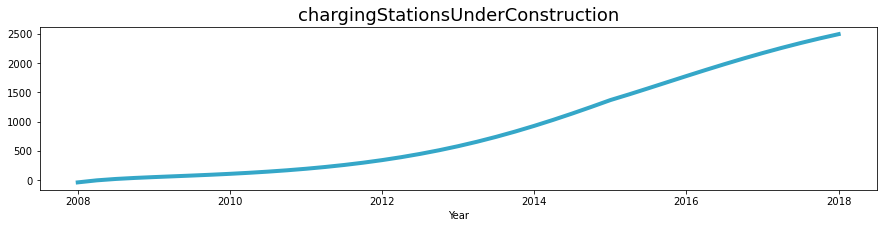

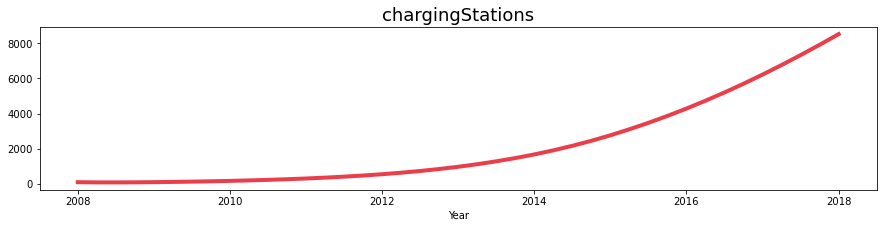

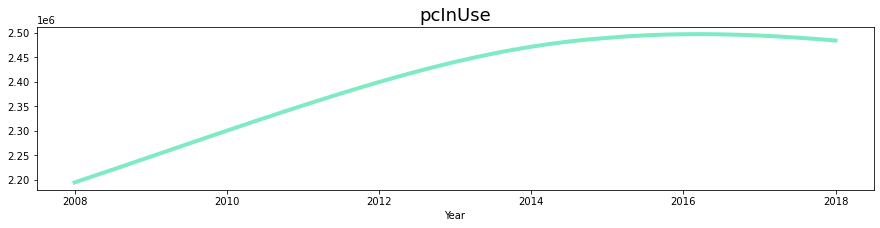

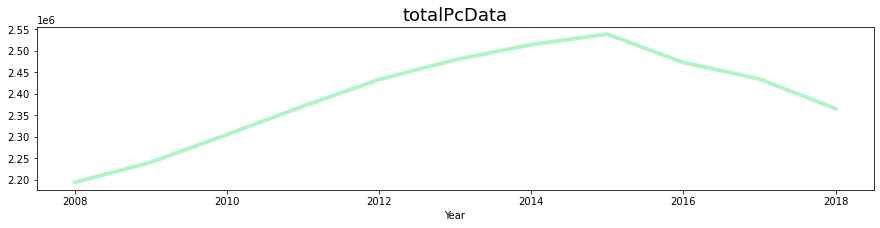

In [ ]:
for col in ["chargingStationsUnderConstruction", "chargingStations", "pcInUse", "totalPcData"]:
    plt.plot(bptk_sd_env.state.obs_timeseries[col], lw=4, c=np.random.rand(3))
    plt.title(col, fontsize=18)
    plt.xlabel("Year")
    plt.show()


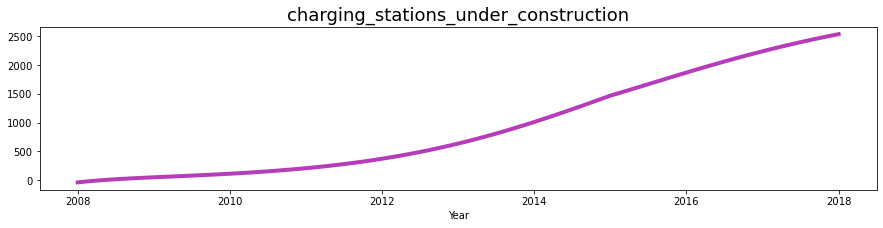

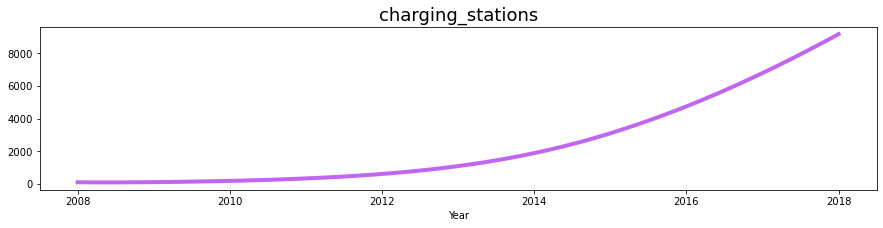

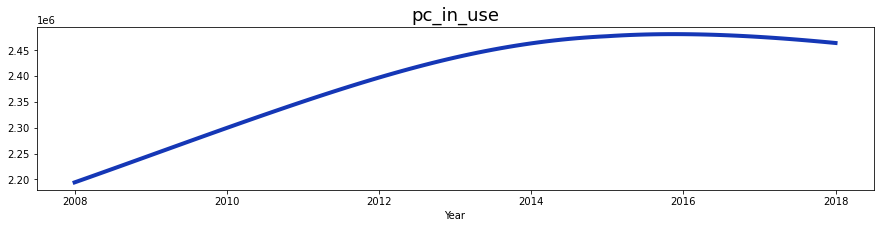

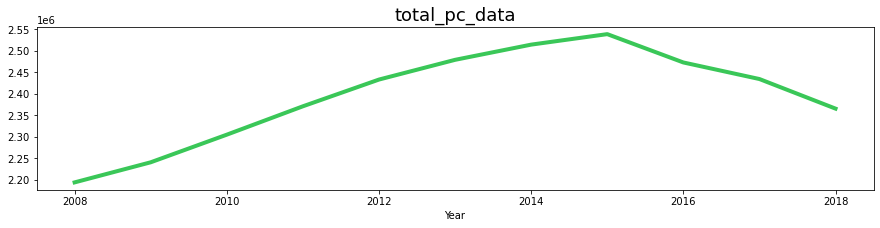

In [ ]:
for col in ["charging_stations_under_construction", "charging_stations", "pc_in_use", "total_pc_data"]:
    plt.plot(pysd_sd_env.state.obs_timeseries[col], lw=4, c=np.random.rand(3))
    plt.title(col, fontsize=18)
    plt.xlabel("Year")
    plt.show()

## Model info (BPTK)

In [ ]:
from sd_gym import util

In [ ]:
parsed_model, info_df = util.sd_info(bptk_sd_env)
info_df

,Variable Name,Observable,Actionable,Type,Equation
ecSales,ecSales,Yes,No,flow,Overall_demand_on_cars*Relative_attractiveness...
ecScrapping,ecScrapping,Yes,No,flow,EC_in_use/Average_car_lifetime
pcSales,pcSales,Yes,No,flow,Relative_attractiveness_of_PC*Overall_demand_o...
pcScrapping,pcScrapping,Yes,No,flow,PC_in_use/Average_car_lifetime
oilProduction,oilProduction,No,Yes,flow,"""Average_petrol_consumption_(non-passenger_car..."
...,...,...,...,...,...
priceOf1LFuel,priceOf1LFuel,Yes,No,aux,Fuel_price*Random_market_situations
pricePcWithoutTaxes,pricePcWithoutTaxes,No,Yes,aux,350000
priceEcWithoutTaxes,priceEcWithoutTaxes,No,Yes,aux,450000
overpaymEffect,overpaymEffect,Yes,No,aux,Effect_of_infrastructure/Charging_stations_per...


# RL Experiments using PySD

### Imports

In [ ]:
from sd_gym import core
from sd_gym import env
from sd_gym import rewards
from sd_gym import wrappers
import gym

import pandas as pd
import numpy as np

In [ ]:
from acme import environment_loop
from acme import specs
from acme import wrappers as acme_wrappers
from acme.agents import agent
from acme.agents.tf import actors
from acme.agents.tf import d4pg
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.utils import loggers
import sonnet as snt

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15, 3]

%matplotlib inline

### Environment setup

In [ ]:
sd_model_filename = "/tmp/electric_vehicles_norway.stmx"

# reward based on increase in fraction of attrativeness of ECs
# reward_fn = rewards.ScalarDeltaReward('relative_attractiveness_of_ec',
#                                       scaling_fn=lambda x: x*100)

# reward based on increase in fraction of ECs in total car population
reward_fn = rewards.ScalarDeltaReward(lambda obs: 100*obs['ec_in_use']/(obs['ec_in_use']+obs['pc_in_use']))

env_params = core.Params(sd_model_filename,
                         env_dt=1.0,
                         sd_dt=.1,
                         sd_units_types={
                             'years': np.int32,
                             'barrel': np.int64,
                             },
                         default_sd_units_limits={
                             'nok/cars': (0, 100000),
                         },
                         sd_var_limits_override={
                             'km_per_one_battery': (10, 1000),
                             'kwh_per_battery': (10, 100),
                             'electricity_price': (1, 10),
                             'price_pc_without_taxes': (10000, 70000),
                             'price_ec_without_taxes': (20000, None),
                             'gov_policy_on_taxes': (0, 1),
                             'oil_industry_capacity': (1000000, 2000000),
                             },
                         categorical_sd_vars={
                             'average_car_lifetime': [1, 3, 5, 7, 10, 15],
                             'vat': [0.15, 0.3, 0.44, 0.5],
                         },
                         actionables=[
                             'average_car_lifetime', # how often cars are taken off the road
                             'km_per_one_battery', # range of electric cars
                             'kwh_per_battery', # charge for battery
                             'electricity_price', # cost of electricity
                             'price_ec_without_taxes', # price of electric cars
                             'price_pc_without_taxes', # price of petrol cars
                             'vat', # tax on purchases
                             'gov_policy_on_taxes', # government tax incentives for adoption (fraction of tax)
                             'oil_industry_capacity', # oil production capacity
                             ],
                         # observables=['pc_in_use', 'ec_in_use'],
                         reward_function=reward_fn,
                         simulator="PySD")
env = wrappers.make_sd_env(env_params)

In [ ]:
environment = acme_wrappers.GymWrapper(env)
environment_spec = specs.make_environment_spec(environment)

print('actions:', environment_spec.actions)
print('observations:', environment_spec.observations)
print('rewards:', environment_spec.rewards)
print('discounts:', environment_spec.discounts)

actions: BoundedArray(shape=(9,), dtype=dtype('float64'), name='action', minimum=[-1. -1. -1. -1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1. 1. 1. 1.])
observations: BoundedArray(shape=(53,), dtype=dtype('float64'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf])
rewards: Array(shape=(), dtype=dtype('float64'), name='reward')
discounts: BoundedArray(shape=(), dtype=dtype('float64'), name='discount', minimum=0.0, maximum=1.0)


### D4PG Agent training

In [ ]:
# Get total number of action dimensions from action spec.
num_dimensions = np.prod(environment_spec.actions.shape, dtype=int)

# Create the shared observation network; here simply a state-less operation.
observation_network = tf2_utils.batch_concat

# Create the deterministic policy network.
policy_network = snt.Sequential([
    networks.LayerNormMLP((256, 256, 256), activate_final=True),
    networks.NearZeroInitializedLinear(num_dimensions),
    networks.TanhToSpec(environment_spec.actions),
])

# Create the distributional critic network.
critic_network = snt.Sequential([
    # The multiplexer concatenates the observations/actions.
    networks.CriticMultiplexer(),
    networks.LayerNormMLP((512, 512, 256), activate_final=True),
    networks.DiscreteValuedHead(vmin=-150., vmax=150., num_atoms=51),
])

In [ ]:
simple_agent = actors.FeedForwardActor(policy_network)

In [ ]:
agent_logger = loggers.TerminalLogger(print_fn=print)
env_loop_logger = loggers.InMemoryLogger()

In [ ]:
# Create the D4PG agent.
d4pg_agent = d4pg.D4PG(
    environment_spec=environment_spec,
    policy_network=policy_network,
    critic_network=critic_network,
    observation_network=observation_network,
    sigma=0.7,
    target_update_period=5,
    min_replay_size=5,
    n_step=5,
    logger=agent_logger,
    checkpoint=False,
)

In [ ]:
# Create an loop connecting this agent to the environment created above.
env_loop = environment_loop.EnvironmentLoop(
    environment, d4pg_agent, logger=env_loop_logger)

env_loop.run(num_episodes=100)

Critic Loss = 3.909 | Policy Loss = 0.000 | Steps = 1 | Walltime = 0
Critic Loss = 3.824 | Policy Loss = 0.000 | Steps = 2 | Walltime = 2.002
Critic Loss = 3.799 | Policy Loss = 0.000 | Steps = 3 | Walltime = 4.564
Critic Loss = 3.758 | Policy Loss = 0.000 | Steps = 4 | Walltime = 5.004
Critic Loss = 3.703 | Policy Loss = 0.000 | Steps = 5 | Walltime = 6.984
Critic Loss = 3.532 | Policy Loss = 0.000 | Steps = 6 | Walltime = 9.675
Critic Loss = 3.514 | Policy Loss = 0.000 | Steps = 7 | Walltime = 11.727
Critic Loss = 3.501 | Policy Loss = 0.000 | Steps = 8 | Walltime = 13.718
Critic Loss = 3.496 | Policy Loss = 0.000 | Steps = 9 | Walltime = 14.160
Critic Loss = 3.498 | Policy Loss = 0.000 | Steps = 10 | Walltime = 16.908
Critic Loss = 3.459 | Policy Loss = 0.000 | Steps = 11 | Walltime = 18.854
Critic Loss = 3.349 | Policy Loss = 0.000 | Steps = 12 | Walltime = 21.535
Critic Loss = 3.316 | Policy Loss = 0.000 | Steps = 13 | Walltime = 23.444
Critic Loss = 3.374 | Policy Loss = 0.000 | 

1000

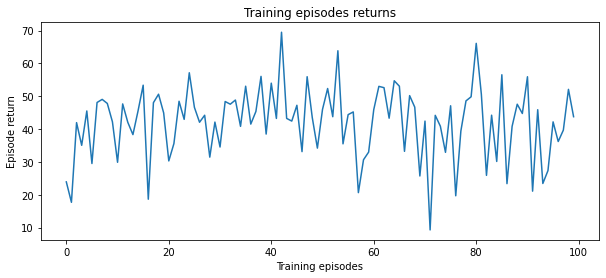

In [ ]:
%matplotlib inline
df = pd.DataFrame(env_loop_logger.data)
plt.figure(figsize=(10, 4))
plt.title('Training episodes returns')
plt.xlabel('Training episodes')
plt.ylabel('Episode return')
plt.plot(df['episode_return']);

### Evals

In [ ]:
def chart_state():
  cols = ["pc_in_use", "ec_in_use"]
  # cols = ['electricity_price', 'kwh_per_battery', 'km_per_one_battery']
  plt.title('state', fontsize=18)
  plt.xlabel("Year")
  plt.plot(env.state.obs_timeseries[cols], label=cols)
  plt.legend()
  plt.show()

In [ ]:
def evaluate_agent_acme(agent: agent.Agent, num_steps=10):
  # Run the actor in the environment for desired number of steps.
  timestep = environment.reset()
  total_reward = 0
  for _ in range(num_steps):
    action = agent.select_action(timestep.observation)
    timestep = environment.step(action)
    total_reward += timestep.reward
  print('cumulative reward:', total_reward)
  chart_state()

cumulative reward: 59.41461148592202


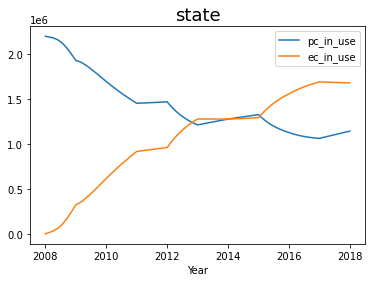

In [ ]:
evaluate_agent_acme(d4pg_agent)

cumulative reward: 28.28019516128719


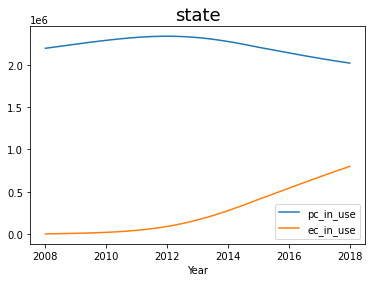

In [ ]:
evaluate_agent_acme(simple_agent)